# Config & Import Libraries

In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# imports time series
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# pip install calmap
#import calmap

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import datetime
import itertools
import pickle
from datetime import timedelta

# apartado ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import xgboost as xgb

# Data Loading

In [2]:
# Leemos los ficheros
ruta = '../data/'
df = pd.read_csv(ruta+'df_forecast.csv')

df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [ ]:
df.head()

,id,qty_sold,holiday,sell_price,year,week,date,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded
0,ACCESORIES_1_001_NYC_1,0.0,1,12.7414,2013,1,2013-01-07,4,3,3,1,1,1
1,ACCESORIES_1_002_NYC_1,1.0,1,5.2801,2013,1,2013-01-07,4,3,3,1,1,2
2,ACCESORIES_1_003_NYC_1,0.0,1,3.9501,2013,1,2013-01-07,4,3,3,1,1,3
3,ACCESORIES_1_004_NYC_1,0.0,1,5.7722,2013,1,2013-01-07,4,3,3,1,1,4
4,ACCESORIES_1_005_NYC_1,1.0,1,4.0964,2013,1,2013-01-07,4,3,3,1,1,5


# Visualizamos las ventas

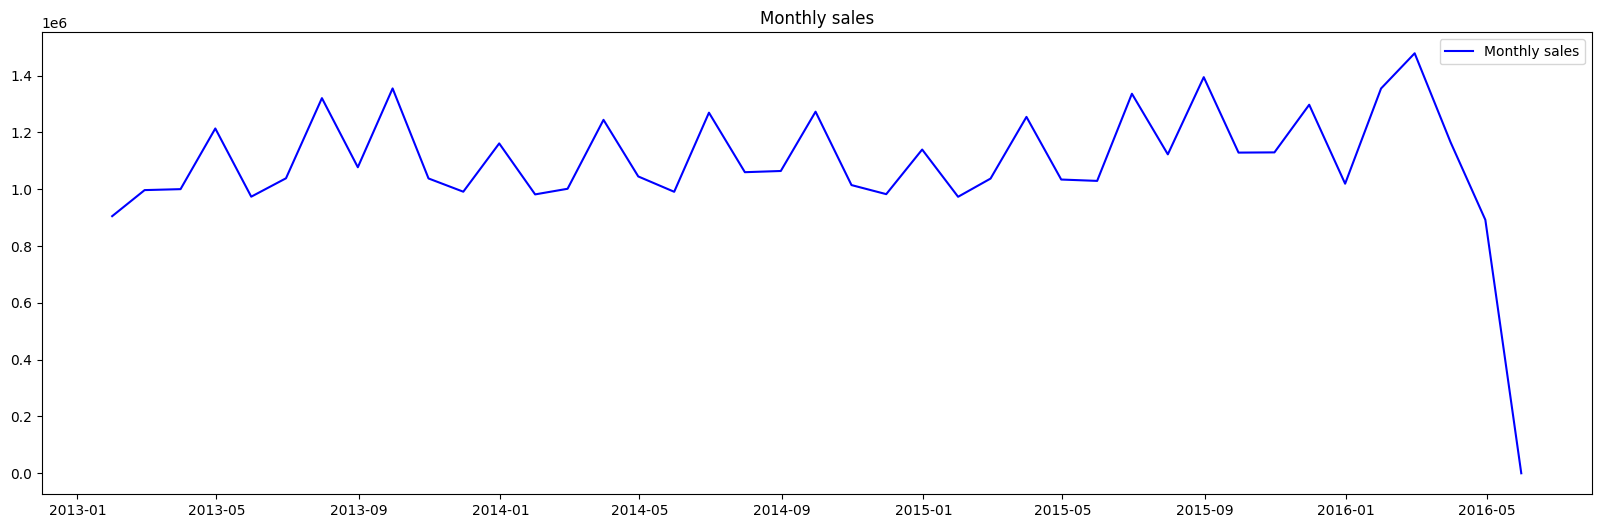

In [ ]:
# Consultamos las ventas mensuales:
x= df[['date', "qty_sold"]].set_index('date').resample("M").sum()

# Vemos la evolución de las ventas mensuales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.title("Monthly sales")
plt.legend()

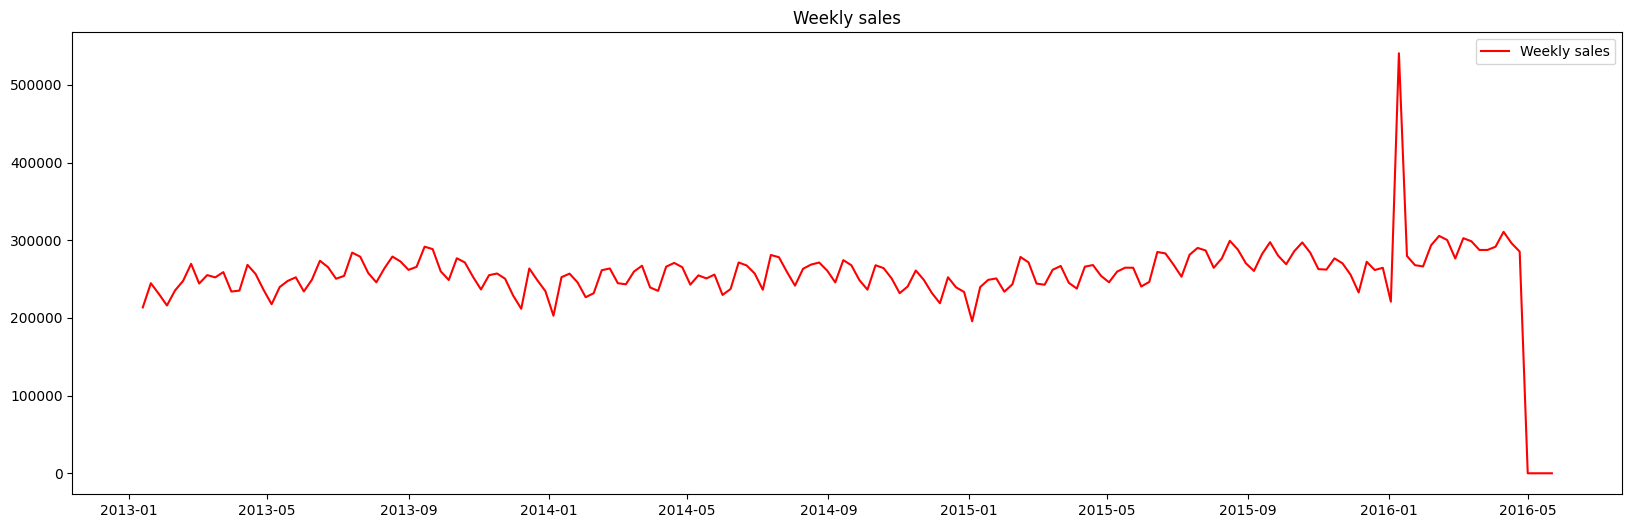

In [ ]:
# Consultamos las ventas semanales:
x= df[['date', "qty_sold"]].set_index('date').resample("W").sum()

# Vemos la evolución de las ventas semanales:
plt.figure(figsize = (20, 6))
plt.plot(x, color = "red", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend()

### EDA: Global Sales

In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

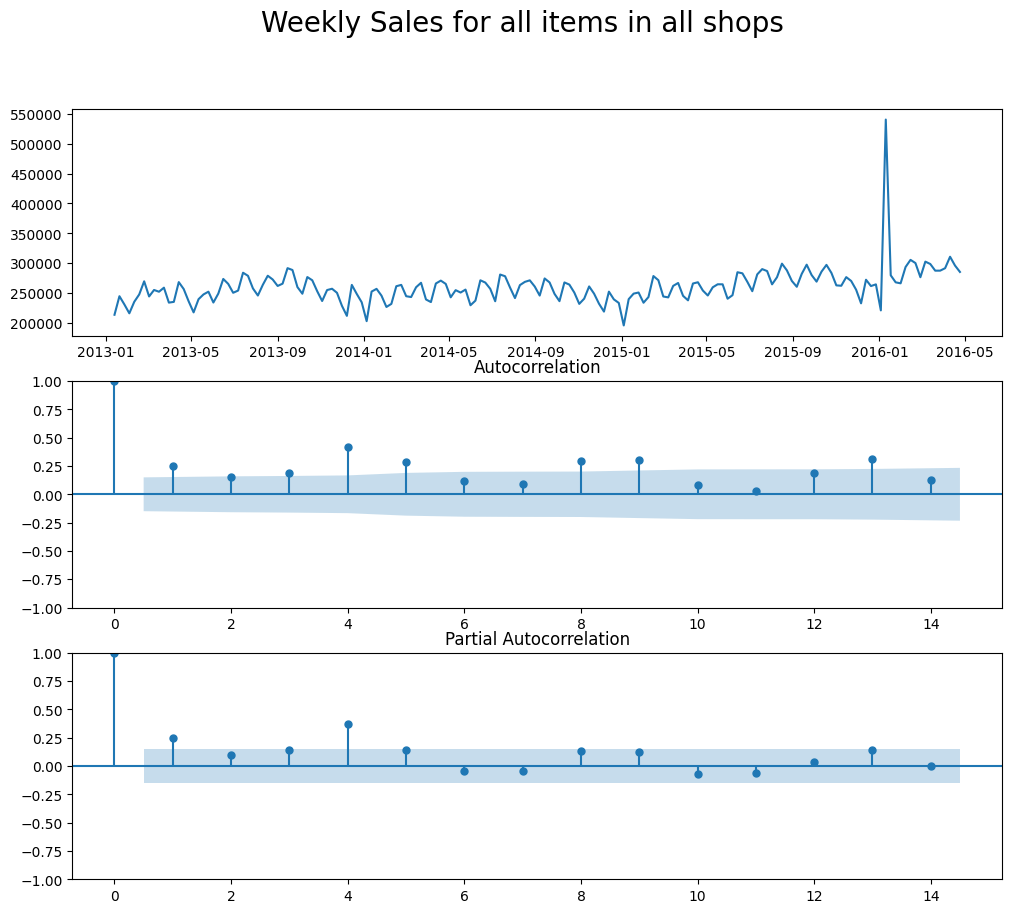

In [ ]:
y = df.set_index("date").resample("W")["qty_sold"].sum()[:-4] # quitamos los registros de las ultimas cuatro semanas.
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops")

# >> Building Time Series Features:

In [3]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("W", origin ='start')[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    gb_df_[f"{new_name}_lag5"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(5)
    )
    gb_df_[f"{new_name}_ma5"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1).rolling(5).mean()
    )
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [4]:
GB_LIST = ['department_encode','item_encoded','store_code_encode']
TARGET_COLUMN = "qty_sold"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)
vars_ts_['date'] = vars_ts_['date'] - timedelta(days=6)
vars_ts_.head(10)

Dropping columns that might cause target leakage department_encode_item_encoded_store_code_encode_qty_sold_sum


,department_encode,item_encoded,store_code_encode,date,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5
0,1,1,1,2013-01-07,NaN,NaN
1,1,1,1,2013-01-14,NaN,NaN
2,1,1,1,2013-01-21,NaN,NaN
3,1,1,1,2013-01-28,NaN,NaN
4,1,1,1,2013-02-04,NaN,NaN
5,1,1,1,2013-02-11,1.0,2.0
6,1,1,1,2013-02-18,1.0,2.6
7,1,1,1,2013-02-25,4.0,3.0
8,1,1,1,2013-03-04,1.0,2.6
9,1,1,1,2013-03-11,3.0,2.8


In [5]:
print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)

(37014860, 13)
(37014860, 15)


In [6]:
df.tail()

,id,qty_sold,holiday,sell_price,year,week,date,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5
37014855,SUPERMARKET_3_827_NYC_3,0.0,0,1.2,2016,20,2016-05-16,6,7,1,1,3,827,39.0,15.4
37014856,SUPERMARKET_3_827_NYC_4,0.0,0,1.2,2016,20,2016-05-16,7,7,1,1,4,827,0.0,4.4
37014857,SUPERMARKET_3_827_PHI_1,0.0,0,1.2,2016,20,2016-05-16,8,7,1,3,8,827,20.0,7.0
37014858,SUPERMARKET_3_827_PHI_2,0.0,0,1.2,2016,20,2016-05-16,9,7,1,3,9,827,17.0,5.8
37014859,SUPERMARKET_3_827_PHI_3,0.0,0,1.2,2016,20,2016-05-16,10,7,1,3,10,827,0.0,0.0


In [7]:
GB_LIST = ['department_encode','item_encoded','store_code_encode']     
TARGET_COLUMN = "sell_price"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)
vars_ts_['date'] = vars_ts_['date'] - timedelta(days=6)
vars_ts_.head(10)

print(df.shape)
df = pd.merge(df, vars_ts_, on = ["date"] + GB_LIST, how = "left")
print(df.shape)

Dropping columns that might cause target leakage department_encode_item_encoded_store_code_encode_sell_price_sum
(37014860, 15)
(37014860, 17)


In [8]:
#df['sales_mean_rolling'] = df.groupby(['id']).resample('W')['qty_sold'].transform(lambda series: series.shift(1).rolling(window = 2).mean())

In [9]:
#df.head(3)

### Train Test Split

In [10]:
df.columns.tolist()

['id',
 'qty_sold',
 'holiday',
 'sell_price',
 'year',
 'week',
 'date',
 'store_encode',
 'department_encode',
 'category_encode',
 'region_encode',
 'store_code_encode',
 'item_encoded',
 'department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5',
 'department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5',
 'department_encode_item_encoded_store_code_encode_sell_price_sum_lag5',
 'department_encode_item_encoded_store_code_encode_sell_price_sum_ma5']

In [11]:
COLUMNS_TO_DROP = [#'store_encode','region_encode','category_encode'
    #'year','week'
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [12]:
df.set_index("id", inplace = True)

In [13]:
df.sample(5)

,qty_sold,holiday,sell_price,year,week,date,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5,department_encode_item_encoded_store_code_encode_sell_price_sum_lag5,department_encode_item_encoded_store_code_encode_sell_price_sum_ma5
id,,,,,,,,,,,,,,,,
SUPERMARKET_3_528_NYC_3,1.0,0,5.9760,2015,44,2015-11-02,6,7,1,1,3,528,1.0,4.0,41.8320,41.8320
HOME_&_GARDEN_2_340_BOS_2,0.0,0,6.2250,2013,13,2013-04-01,2,2,2,2,6,340,0.0,0.2,43.7500,43.6800
HOME_&_GARDEN_2_507_NYC_1,0.0,0,8.7125,2014,19,2014-05-12,4,2,2,1,1,507,2.0,3.0,60.9875,60.9875
SUPERMARKET_2_308_BOS_1,0.0,0,3.3840,2015,17,2015-04-27,1,6,1,2,5,308,5.0,2.0,23.6880,23.6880
ACCESORIES_1_063_BOS_2,0.0,0,7.2751,2014,25,2014-06-23,2,3,3,2,6,63,0.0,1.6,50.9257,50.9257


In [14]:
# Hacemos el split del dataset:
X_train = df[(df['date'] <= '2016-03-21')].drop(['qty_sold', "date"], axis=1)
Y_train = df[(df['date'] <= '2016-03-21')]['qty_sold']

X_valida = df[(df['date'] >= '2016-03-28') & (df['date'] <= '2016-04-18')].drop(['qty_sold', "date"], axis=1)
Y_valida = df[(df['date'] >= '2016-03-28') & (df['date'] <= '2016-04-18')]['qty_sold']

X_test = df[(df['date'] >= '2016-04-25')].drop(['qty_sold', "date"], axis = 1)
Y_test = df[(df['date'] >= '2016-04-25')]['qty_sold']

In [15]:
X_train.tail(3)

,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5,department_encode_item_encoded_store_code_encode_sell_price_sum_lag5,department_encode_item_encoded_store_code_encode_sell_price_sum_ma5
id,,,,,,,,,,,,,,
SUPERMARKET_3_825_PHI_3,1,4.776,2016,12,10,7,1,3,10,825,4.0,7.4,33.432,33.432
SUPERMARKET_3_826_PHI_3,1,1.536,2016,12,10,7,1,3,10,826,9.0,6.6,10.752,10.752
SUPERMARKET_3_827_PHI_3,1,1.200,2016,12,10,7,1,3,10,827,9.0,11.2,8.400,8.400


In [16]:
Y_valida.tail(3)

id
SUPERMARKET_3_825_PHI_3    0.0
SUPERMARKET_3_826_PHI_3    3.0
SUPERMARKET_3_827_PHI_3    0.0
Name: qty_sold, dtype: float64

# Hiper-parametrizacion

In [17]:
'''from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 75, 100, 150],
    'max_depth': [5, 6, 7],
    'gamma' : [0, 0.1, 0.2],
#    'reg_alpha' : [0, 0.1, 0.01],
#    'reg_lambda': [0.9, 1, 1.1],
    'learning_rate' : [0.1, 0.25, 0.3]
}

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)

model = grid_search.best_estimator_'''

"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'n_estimators': [50, 75, 100, 150],\n    'max_depth': [5, 6, 7],\n    'gamma' : [0, 0.1, 0.2],\n#    'reg_alpha' : [0, 0.1, 0.01],\n#    'reg_lambda': [0.9, 1, 1.1],\n    'learning_rate' : [0.1, 0.25, 0.3]\n}\n\ngrid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')\ngrid_search.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = False)\n\nmodel = grid_search.best_estimator_"

In [18]:
'''print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", grid_search.best_estimator_)
print("\n The best RMSE:", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'''

'print("---- Results from Random Search -----" )\nprint("\n The best estimator across ALL searched params:", grid_search.best_estimator_)\nprint("\n The best RMSE:", grid_search.best_score_)\nprint("\n The best parameters across ALL searched params:\n", grid_search.best_params_)'

# Model Train

In [19]:
model = xgb.XGBRegressor(
              eval_metric = "rmse",
              seed = 175
#              , n_estimators = 75
#              , max_depth = 6
#              , gamma = 0
#              , reg_alpha =0
#              , reg_lambda = 1
#              , learning_rate = 0.1
              )

model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose = 10)

[0]	validation_0-rmse:3.24612	validation_1-rmse:2.97964
[10]	validation_0-rmse:2.49551	validation_1-rmse:2.18147
[20]	validation_0-rmse:2.46372	validation_1-rmse:2.16698
[30]	validation_0-rmse:2.43753	validation_1-rmse:2.16123
[40]	validation_0-rmse:2.42192	validation_1-rmse:2.15885
[50]	validation_0-rmse:2.40168	validation_1-rmse:2.15762
[60]	validation_0-rmse:2.38472	validation_1-rmse:2.15773
[70]	validation_0-rmse:2.37176	validation_1-rmse:2.15803
[80]	validation_0-rmse:2.36019	validation_1-rmse:2.15834
[90]	validation_0-rmse:2.35293	validation_1-rmse:2.15733
[99]	validation_0-rmse:2.34396	validation_1-rmse:2.15628


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### >> Model Evaluation

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

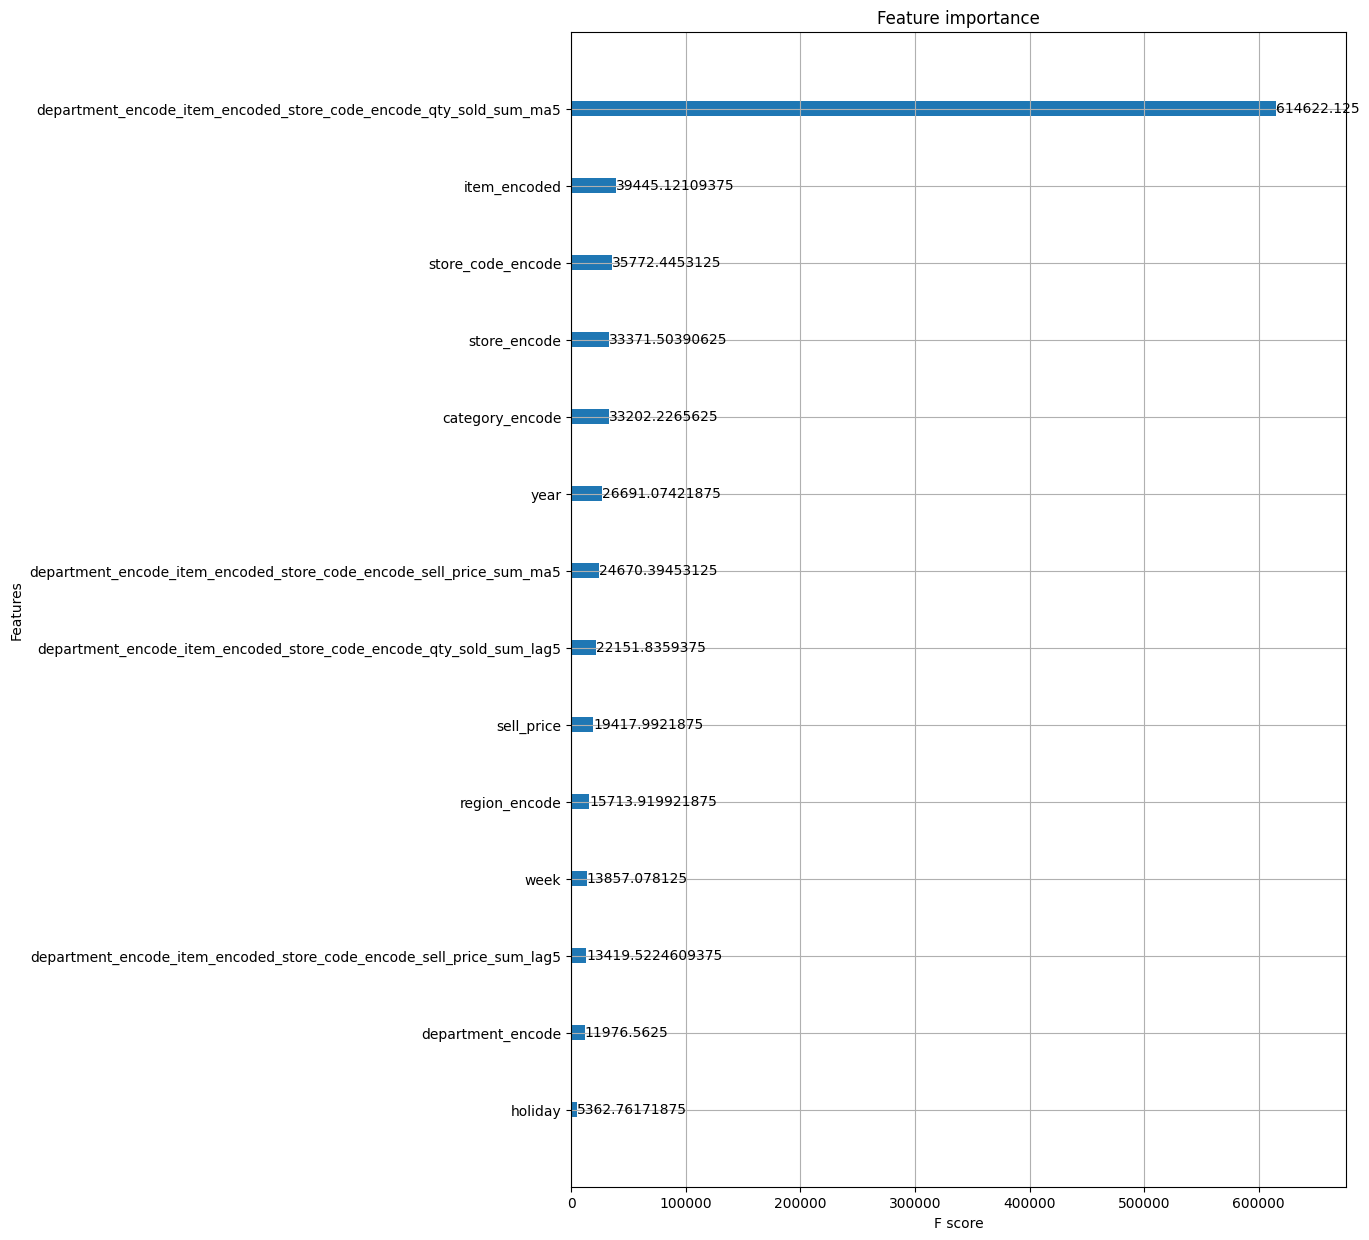

In [20]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax)

# Prediction

In [21]:
if "qty_sold" in X_test.columns:
    X_test.drop("qty_sold", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["qty_sold"] = Y_test_predict

In [22]:
X_test.reset_index(inplace = True)

In [23]:
X_test.tail()

,id,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5,department_encode_item_encoded_store_code_encode_sell_price_sum_lag5,department_encode_item_encoded_store_code_encode_sell_price_sum_ma5,qty_sold
121955,SUPERMARKET_3_827_NYC_3,0,1.2,2016,20,6,7,1,1,3,827,39.0,15.4,8.4,4.08,2.502794
121956,SUPERMARKET_3_827_NYC_4,0,1.2,2016,20,7,7,1,1,4,827,0.0,4.4,8.4,4.08,1.766650
121957,SUPERMARKET_3_827_PHI_1,0,1.2,2016,20,8,7,1,3,8,827,20.0,7.0,8.4,4.08,1.081222
121958,SUPERMARKET_3_827_PHI_2,0,1.2,2016,20,9,7,1,3,9,827,17.0,5.8,8.4,4.08,0.675176
121959,SUPERMARKET_3_827_PHI_3,0,1.2,2016,20,10,7,1,3,10,827,0.0,0.0,8.4,4.08,1.410237


In [24]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [25]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_344
Validation RMSE: 2_156


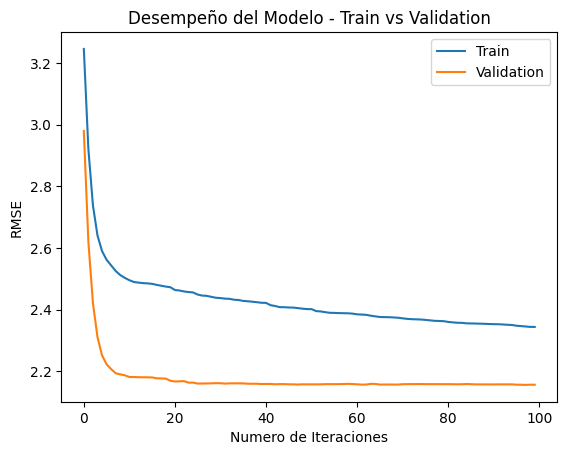

In [26]:
# Obtener métricas
results = model.evals_result()
# Gráfica de métricas
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# Métricas de entrenamiento
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
# Métricas de validação
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.xlabel('Numero de Iteraciones')
plt.ylabel('RMSE')
plt.title('Desempeño del Modelo - Train vs Validation')
plt.show()

In [27]:
X_test.tail(3)

,id,holiday,sell_price,year,week,store_encode,department_encode,category_encode,region_encode,store_code_encode,item_encoded,department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5,department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5,department_encode_item_encoded_store_code_encode_sell_price_sum_lag5,department_encode_item_encoded_store_code_encode_sell_price_sum_ma5,qty_sold
121957,SUPERMARKET_3_827_PHI_1,0,1.2,2016,20,8,7,1,3,8,827,20.0,7.0,8.4,4.08,1.081222
121958,SUPERMARKET_3_827_PHI_2,0,1.2,2016,20,9,7,1,3,9,827,17.0,5.8,8.4,4.08,0.675176
121959,SUPERMARKET_3_827_PHI_3,0,1.2,2016,20,10,7,1,3,10,827,0.0,0.0,8.4,4.08,1.410237


In [28]:
X_test['qty_sold'] = X_test['qty_sold'].astype(int)

In [29]:
# Resultado de la prediccion:
X_test[['year','week','id','qty_sold']]

,year,week,id,qty_sold
0,2016,17,ACCESORIES_1_001_BOS_1,0
1,2016,17,ACCESORIES_1_001_BOS_2,0
2,2016,17,ACCESORIES_1_001_BOS_3,0
3,2016,17,ACCESORIES_1_001_NYC_1,0
4,2016,17,ACCESORIES_1_001_NYC_2,0
...,...,...,...,...
121955,2016,20,SUPERMARKET_3_827_NYC_3,2
121956,2016,20,SUPERMARKET_3_827_NYC_4,1
121957,2016,20,SUPERMARKET_3_827_PHI_1,1
121958,2016,20,SUPERMARKET_3_827_PHI_2,0


In [30]:
X_test[['year','week','id','qty_sold']].to_csv(ruta+'forecast_prediction.csv', index = False)

In [31]:
'''Train RMSE: 3_553
Validation RMSE: 3_294
Diferencia = 0.259

Dataset estandard
-----------------------------------------
Train RMSE: 2_265
Validation RMSE: 2_113
Diferencia = 0.152

'store_encode_id_qty_sold_sum_lag1',
'store_encode_id_qty_sold_sum_ma3'
-----------------------------------------
Train RMSE: 2_316
Validation RMSE: 2_142
Diferencia = 0.175

 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_lag5',
 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_ma5'
-----------------------------------------
Train RMSE: 2_315
Validation RMSE: 2_137
Diferencia = 0.178

Borre: category, store y region. 
-----------------------------------------
Train RMSE: 2_344
Validation RMSE: 2_147
Diferencia = 0.197

'department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5',
 'department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5',
 'department_encode_item_encoded_store_code_encode_qty_sold_sum_ma6',
 'department_encode_item_encoded_store_code_encode_qty_sold_sum_ma7',
 'department_encode_item_encoded_store_code_encode_sell_price_sum_lag5',
 'department_encode_item_encoded_store_code_encode_sell_price_sum_ma5',
 'department_encode_item_encoded_store_code_encode_sell_price_sum_ma6',
 'department_encode_item_encoded_store_code_encode_sell_price_sum_ma7'
-----------------------------------------
Train RMSE: 2_344
Validation RMSE: 2_156
Diferencia = 0.188

'''

"Train RMSE: 3_553\nValidation RMSE: 3_294\nDiferencia = 0.259\n\nDataset estandard\n-----------------------------------------\nTrain RMSE: 2_265\nValidation RMSE: 2_113\nDiferencia = 0.152\n\n'store_encode_id_qty_sold_sum_lag1',\n'store_encode_id_qty_sold_sum_ma3'\n-----------------------------------------\nTrain RMSE: 2_316\nValidation RMSE: 2_142\nDiferencia = 0.175\n\n 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_lag5',\n 'category_encode_department_encode_item_encoded_region_encode_store_code_encode_qty_sold_sum_ma5'\n-----------------------------------------\nTrain RMSE: 2_315\nValidation RMSE: 2_137\nDiferencia = 0.178\n\nBorre: category, store y region. \n-----------------------------------------\nTrain RMSE: 2_344\nValidation RMSE: 2_147\nDiferencia = 0.197\n\n'department_encode_item_encoded_store_code_encode_qty_sold_sum_lag5',\n 'department_encode_item_encoded_store_code_encode_qty_sold_sum_ma5',\n 'department_encode_item_encod